# Feature Engineering, Preprocessing and EDA

## Author: Tilova Shahrin

### Modelling Ideas
- Time Series Analysis: Perform time series analysis to forecast the number of infractions over time. This could involve using techniques like ARIMA or SARIMA models.

- Infraction Frequency Analysis: Build a linear regression model to predict the frequency of infractions based on factors like time of day, day of the week, or month of the year.

Table of Contents:
- [Importing and Reading Dataframe](#reading)
- [Coordinates API using Geopy](#geoapi)
- [Separating Datetime](#datetime)
- [Parking Infraction EDA](#infreda)
- [Grouping Parking Infractions](#clusterinfr)

<a id='reading'></a>
### Importing and Reading Dataframe

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import os
import glob
import datetime
from geopy.geocoders import Nominatim
import time

Recall we downloaded a new csv file from our cleaning in the last file `Cleaning and EDA`. Let's upload the file into a dataframe.

In [3]:
parking_df = pd.read_csv('../data/parking_df.csv')

In [3]:
parking_df.head()

date_of_infraction  infraction_code         infraction_description  \
0         2016-12-30            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR   
1         2016-12-30            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR   
2         2016-12-30            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR   
3         2016-12-30            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR   
4         2016-12-30            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR   

   set_fine_amount time_of_infraction location1         location2 location3  \
0              150           16:37:00       N/S   1546 BLOOR ST W       NaN   
1              150           16:37:00       N/S     5418 YONGE ST       NaN   
2              150           16:37:00       OPP    777 QUEEN ST W       NaN   
3              150           16:37:00       N/S    747 QUEEN ST E       NaN   
4              150           16:37:00       N/S  3042 DUNDAS ST W       NaN   

  location4 province datetime_of_infraction  
0       NaN       ON    2016-12-30 16:37:00  
1       NaN       ON    2016-12-30 16:37:00  
2       NaN       ON    2016-12-30 16:37:00  
3       NaN       ON    2016-12-30 16:37:00  
4       NaN       ON    2016-12-30 16:37:00

In [4]:
parking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960604 entries, 0 to 12960603
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   date_of_infraction      object 
 1   infraction_code         float64
 2   infraction_description  object 
 3   set_fine_amount         int64  
 4   time_of_infraction      object 
 5   location1               object 
 6   location2               object 
 7   location3               object 
 8   location4               object 
 9   province                object 
 10  datetime_of_infraction  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.1+ GB


In [5]:
parking_df.duplicated().sum()

0

In [23]:
parking_df['datetime_of_infraction'] = parking_df['datetime_of_infraction'].astype('datetime64[ns]')

<a id='geoapi'></a>
## Coordinates API using Geopy

I want to find a way to produce geospatial analysis for my machine learning models. With that, I need geo coordinates `latitude` and `longitude`. 

We're going to use this code snippet to change address to a coordinate. However, we need to run this geolocator a lot of times.  

In [7]:
import pandas as pd
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="toronto-parking-application")
location = geolocator.geocode("Edward St Toronto ON Canada")
print(location.address)
print((location.latitude, location.longitude))

Edward Street, Discovery District, University—Rosedale, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5B 1R7, Canada
(43.6566007, -79.3831637)


Recall the shape. That is a lot of rows to process, about 13 million, even after cleaning this is going to take a while. We need to find a way to reduce the amount of API calls!

In [8]:
parking_df.shape

(12960604, 11)

Let's get the unique values of the addresses, and apply those addresses onto any duplicate addresses. Recall the addresses with the most tickets. Some have about 30 thousand tickets. To reduce, we get the unique value, add to dictionary and find a way to use that same address after getting the coordinate. 

In [9]:
parking_df['location2'].nunique()

482566

About 400k unique values. That is a lot less than the number of rows. We can use these addresses and process them onto the API. 

In [10]:
parking_df['location2'].unique()

array(['1546 BLOOR ST W', '5418 YONGE ST', '777 QUEEN ST W', ...,
       '28 LAMBERTON BLVD', '30151 GLENDALE AVE', '576 FORMAN AVE'],
      dtype=object)

Since I've decided to keep location2 as the main column to find the coordinates, I won't need location3/4 and province. 

In [18]:
parking_df.drop(columns = ['location3', 'location4'], inplace=True)

Let's write the code to call Geopy's Nominatim so that it may return the coordinates.

In [9]:
def geocode_address(address):
    geolocator = Nominatim(user_agent="toronto-parking-application")
    location = geolocator.geocode(address, timeout=10)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

The follwing code allows us to grab the unique addresses of the location2 column and grab the coordinates of each unique address. As mentioned before, we have 400k unique addresses. Going through this code will take a very long time, we not be able to go through everything, so in case it does not crash I will save addresses onto a json file, through every 100 iterations.  

In [ ]:
import json
from IPython.display import clear_output

#opens existing json file
f = open('address_data.json')
data = json.load(f)
f.close()

#initialize count
count = 0

#get all the unique addresses in lower case
unique_addresses = parking_df['location2'].str.lower().unique()


try:
    for address in unique_addresses:
        #add city, province and country to address to get an accurate coordinate
        address += ', toronto, on, canada'
        
        #if address isn't in dictionary
        if address not in data.keys():
            clear_output(wait=True)
            print(round(len(data.keys())/parking_df['location2'].nunique()*100, 4), flush=True)
            
            #add count
            count += 1
            
            #get coordinates from api geocode_address
            coord = geocode_address(address)
            
            #add to dictionary
            data[address] = coord
            
            if count == 100:
                #once we save 100 coordinates, write onto json file
                with open('address_data.json', 'w') as json_file:
                    json.dump(data, json_file)

                # Reset the counter
                counter = 0
                
#if I need to stop, dump coordinates from the dict into json              
except KeyboardInterrupt:
    print("Saving the collected data to a JSON file.")
    with open('address_data.json', 'w') as json_file:
        json.dump(data, json_file)
    raise

Since I cannot process everything. I will sample as much as I can. Let's see how much the length of our data dict equals to based on our dataframe. 

In [4]:
import json
f = open('address_data.json')
data = json.load(f)
len(data)/parking_df['location2'].nunique()*100

26.773747010771583

Our dictionary has about ~26% of our dataframe. Thats a good amount of coordinates to have (including null values returned). If I had a faster way of processing these coordinates, I could. However, I can only process this much with the time and resources I have. 

We can create the new columns `latitude` and `longitude`. Also, specify the address so we can have an accurate coordinate by adding city, province, country in the cell. 

Fill null coorindates with 0.0 firstly, so we may run the dictionary.

In [19]:
parking_df['latitude'] = 0.0
parking_df['longitude'] = 0.0

Now specify the city, province and country for the api. 

In [ ]:
parking_df['location2'] += ', TORONTO, ON, CANADA'

Now let's apply these coordinates onto the new columns in the dataframe. 

In [39]:
import json

with open('address_data.json', 'r') as json_file:
    data = json.load(json_file)
    
for address in data.keys():
    if address in parking_df['location2'].str.lower().unique():
        latitude, longitude = data[address]
        
        row_index = parking_df.index[parking_df['location2'].str.lower() == address]
    
        parking_df.loc[row_index, 'latitude'] = latitude
        parking_df.loc[row_index, 'longitude'] = longitude

KeyboardInterrupt: 

Let's save these coordinates onto our csv.

In [40]:
parking_df.to_csv('../data/parking_df.csv', index=False)

In [11]:
parking_df.isna().sum()

date_of_infraction        0
infraction_code           0
infraction_description    0
set_fine_amount           0
time_of_infraction        0
location1                 0
location2                 0
province                  0
datetime_of_infraction    0
latitude                  0
longitude                 0
dtype: int64

There are some null values that our Api could not find coordinates to, we can drop those rows as they are a pretty small amount.

In [9]:
parking_df.dropna(subset=['latitude'],inplace=True)
parking_df.dropna(subset=['longitude'],inplace=True)
parking_df.dropna(subset=['infraction_code'],inplace=True)
parking_df.dropna(subset=['province'],inplace=True)

In [10]:
parking_df.to_csv('../data/parking_df.csv', index=False)

<a id='datetime'></a>
### Separating Datetime

Checking dtype of `datetime_of_infraction` and making sure its `datetime[ns]64`

In [25]:
parking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12942258 entries, 0 to 12942257
Data columns (total 11 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_of_infraction      object        
 1   infraction_code         float64       
 2   infraction_description  object        
 3   set_fine_amount         int64         
 4   time_of_infraction      object        
 5   location1               object        
 6   location2               object        
 7   province                object        
 8   datetime_of_infraction  datetime64[ns]
 9   latitude                float64       
 10  longitude               float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 1.1+ GB


Extracting year, month, and day into separate columns.

In [26]:
parking_df['year'] = parking_df['datetime_of_infraction'].dt.year
parking_df['month'] = parking_df['datetime_of_infraction'].dt.month
parking_df['day'] = parking_df['datetime_of_infraction'].dt.day

Let's reorder this dataframe before saving. 

In [27]:
parking_df = parking_df[['datetime_of_infraction', 'time_of_infraction', 'year', 'month', 'day', 'infraction_code', 'infraction_description', 'set_fine_amount', 'location2', 'province', 'latitude', 'longitude']]

In [28]:
parking_df.head()

datetime_of_infraction time_of_infraction  year  month  day  \
0    2016-12-30 16:37:00           16:37:00  2016     12   30   
1    2016-12-30 16:37:00           16:37:00  2016     12   30   
2    2016-12-30 16:37:00           16:37:00  2016     12   30   
3    2016-12-30 16:37:00           16:37:00  2016     12   30   
4    2016-12-30 16:37:00           16:37:00  2016     12   30   

   infraction_code         infraction_description  set_fine_amount  \
0            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   
1            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   
2            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   
3            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   
4            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   

                               location2 province   latitude  longitude  
0   1546 BLOOR ST W, TORONTO, ON, CANADA       ON  43.656337 -79.453142  
1     5418 YONGE ST, TORONTO, ON, CANADA       ON  43.775587 -79.414671  
2    777 QUEEN ST W, TORONTO, ON, CANADA       ON  43.646259 -79.408080  
3    747 QUEEN ST E, TORONTO, ON, CANADA       ON  43.659131 -79.348080  
4  3042 DUNDAS ST W, TORONTO, ON, CANADA       ON  43.665651 -79.470785

<a id='infreda'></a>
### Parking Infractions EDA

In [5]:
pd.crosstab(index=parking_df['infraction_description'], columns='count').nlargest(10,'count')

col_0                             count
infraction_description                 
PARK ON PRIVATE PROPERTY        2474129
PARK-SIGNED HWY-PROHIBIT DY/TM  2056487
PARK PROHIBITED TIME NO PERMIT  1828730
PARK MACHINE-REQD FEE NOT PAID  1568246
STOP-SIGNED HWY-PROHIBIT TM/DY   677456
PARK - LONGER THAN 3 HOURS       582277
STAND VEH.-PROHIBIT TIME/DAY     454731
PARK-VEH. W/O VALID ONT PLATE    362811
PARK-SIGNED HWY-EXC PERMT TIME   349469
STOP-SIGNED HIGHWAY-RUSH HOUR    338093

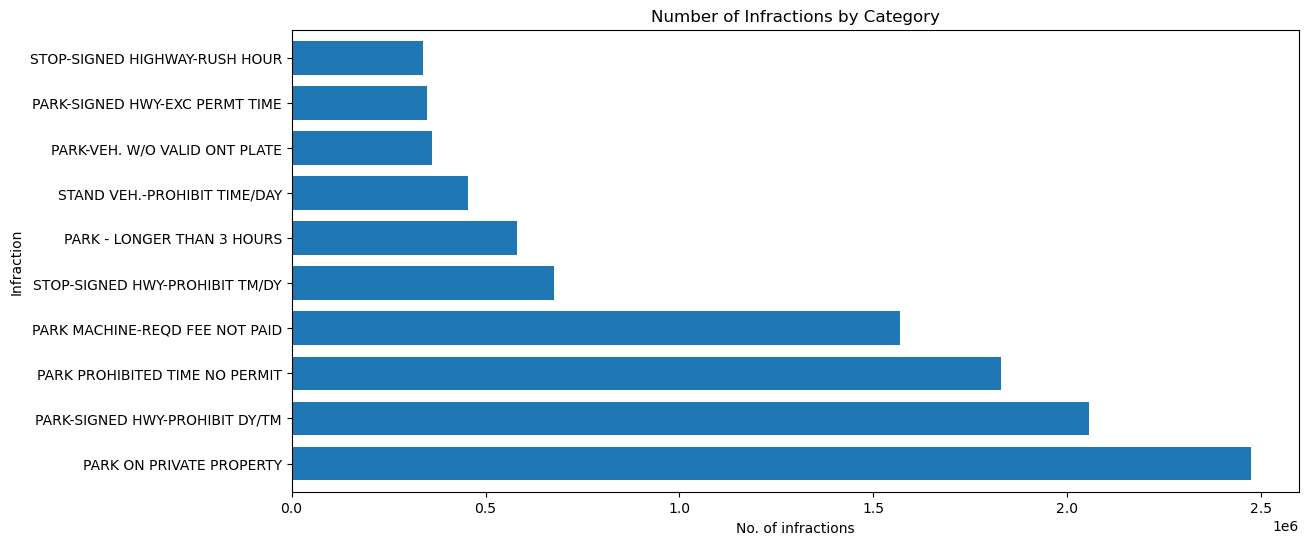

In [72]:
parking_df['infraction_description'].value_counts().nlargest(10).plot(kind='barh',width = 0.75,figsize=(13,6))
plt.title("Top 10 Count of Infractions by Category")
plt.ylabel("Infraction")
plt.xlabel("No. of infractions")
plt.show()

In [12]:
parking_df.groupby('infraction_description')['set_fine_amount'].mean().nlargest(10)

infraction_description
PARK PRIVATE VEHICLE ON SITE      500.00000
STAND ACCESSIBLE NOT DROP OFF     450.00000
STAND IN ACCESSIBLE NO PERMIT     450.00000
STND ACCESSIBLE LOAD NO PERMIT    450.00000
STND ACCESSIBLE LOAD NOT DRP/O    450.00000
STND ONSTRT ACCESSIBLE NO PRMT    450.00000
STND ONSTRT ACCESSIBLE NOT D/O    450.00000
STOP ONSTRT ACCESSIBLE NO PRMT    450.00000
PARK IN ACCESSIBLE NO PERMIT      449.96337
PARK ACCESSIBLE NOT DROP OFF      449.85000
Name: set_fine_amount, dtype: float64

I want to know where exactly is this private property that everyone keeps getting ticketed at. 

In [10]:
infr_df = parking_df[parking_df['infraction_description'] == 'PARK ON PRIVATE PROPERTY']

parking_df['infraction_description'].value_counts().head(50)

infraction_description
PARK ON PRIVATE PROPERTY          2472387
PARK-SIGNED HWY-PROHIBIT DY/TM    2054610
PARK PROHIBITED TIME NO PERMIT    1825548
PARK MACHINE-REQD FEE NOT PAID    1564515
STOP-SIGNED HWY-PROHIBIT TM/DY     675892
PARK - LONGER THAN 3 HOURS         582210
STAND VEH.-PROHIBIT TIME/DAY       454491
PARK-VEH. W/O VALID ONT PLATE      362221
PARK-SIGNED HWY-EXC PERMT TIME     348982
STOP-SIGNED HIGHWAY-RUSH HOUR      338093
PARK FAIL TO DISPLAY RECEIPT       210637
PARK-WITHIN 3M OF FIRE HYDRANT     190219
PARK ON MUNICIPAL PROPERTY         183479
PARKING MACH-NOT USED/NO FEE       181106
PARK-N.YORK 2AM-6AM DEC1-MAR31     164744
STAND SIGNED TRANSIT STOP          128166
PARK - LONGER THAN 3 HOURS         109700
PARK COMMERC LOAD ZONE NOT LDG     108757
STOP-(ON/OVER) (SIDEWK/FTPATH)      89341
PARK IN A FIRE ROUTE                83888
PARK-SIGNED HWY-PUBLIC LANE         77402
PARK-WITHIN 9M INTERSECT ROAD       59655
PARK - ON BOULEVARD                 51222
STOP VEH OT

In [7]:
infr_df['set_fine_amount'].unique()

array([30])

From what we know, 4700 Keele St is a bus loop for york university campus.

2075 Bayview ave is a hostpital. These two are the most common tickets given based on the highest count of infraction named 'park on private property'. Charged with 30 dollars each time. 

I want to find a way to classify these infractions. Let's group them in a dictionary and use keywords to find the related infractions. 

<a id='clusterinfr'></a>
### Grouping Infractions

In [14]:
infraction_groups = {
    'permit_time_restrictions': [
        "PARK-SIGNED HWY-PROHIBIT DY/TM",
        "PARK PROHIBITED TIME NO PERMIT",
        "PARK-SIGNED HWY-EXC PERMT TIME",
        "PARK-N.YORK 2AM-6AM DEC1-MAR31",
        "PARK - NOT WITHIN PERIOD"
    ],
    'fee_related': [
        "PARK MACHINE-REQD FEE NOT PAID",
        "PARK FAIL TO DISPLAY RECEIPT",
        "PARKING MACH-NOT USED/NO FEE",
        "PARK FAIL TO DEPOSIT FEE METER"
    ],
    'time_related': [
        "PARK - LONGER THAN 3 HOURS",
        "STAND VEH.-PROHIBIT TIME/DAY",
        "STOP-SIGNED HIGHWAY-RUSH HOUR"
    ],
    'plate_related': [
        "PARK-VEH. W/O VALID ONT PLATE",
        "PARK-W/O VALID NON-ONT PLATE"
    ],
    'fire_route': [
        "PARK-WITHIN 3M OF FIRE HYDRANT",
        "PARK IN A FIRE ROUTE"
    ],
    'accessible_related': [
        "STND ONSTRT ACCESSIBLE NO PRMT",
        "PARK ONSTRT ACCESSIBLE NO PRMT",
        "PARK IN ACCESSIBLE NO PERMIT"
    ],
    'commercial_related': [
        "PARK COMMERC LOAD ZONE NOT LDG",
        "PARK VEH.-COMMERCIAL LOAD ZONE"
    ],
    'obstruction_related': [
        "PARK-OBSTRUCT (DRWAY/LANEWAY)",
        "PARK IN PARK NOT IN DESIG AREA",
        "FAIL TO PARK/STOP PARALL. CURB",
        "PARK CONTRARY POSTED CONDITION",
        "PARK VEHICLE OUTSIDE OF SPACE",
        "STOP-(ON/OVER) (SIDEWK/FTPATH)"
    ],
    'cycle_related': [
        "STOP NON-BICYCLE IN CYCLE TRCK",
        "STOP VEH OTR THN BCYCL-BYCL LN"
    ]
}

In [13]:
infraction_groups.keys()

dict_keys(['permit_time_restrictions', 'fee_related', 'time_related', 'plate_related', 'fire_route', 'accessible_related', 'commercial_related', 'obstruction_related', 'cycle_related'])

In [15]:
for group, keywords in infraction_groups.items():
    parking_df[group] = parking_df['infraction_description'].apply(lambda x: 1 if any(keyword in x for keyword in keywords) else 0)

    
parking_df.head()

datetime_of_infraction time_of_infraction  year  month  day  \
0    2016-12-30 16:37:00           16:37:00  2016     12   30   
1    2016-12-30 16:37:00           16:37:00  2016     12   30   
2    2016-12-30 16:37:00           16:37:00  2016     12   30   
3    2016-12-30 16:37:00           16:37:00  2016     12   30   
4    2016-12-30 16:37:00           16:37:00  2016     12   30   

   infraction_code         infraction_description  set_fine_amount  \
0            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   
1            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   
2            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   
3            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   
4            403.0  STOP-SIGNED HIGHWAY-RUSH HOUR              150   

                               location2 province  ...  longitude  \
0   1546 BLOOR ST W, TORONTO, ON, CANADA       ON  ... -79.453142   
1     5418 YONGE ST, TORONTO, ON, CANADA       ON  ... -79.414671   
2    777 QUEEN ST W, TORONTO, ON, CANADA       ON  ... -79.408080   
3    747 QUEEN ST E, TORONTO, ON, CANADA       ON  ... -79.348080   
4  3042 DUNDAS ST W, TORONTO, ON, CANADA       ON  ... -79.470785   

   permit_time_restrictions  fee_related  time_related  plate_related  \
0                         0            0             1              0   
1                         0            0             1              0   
2                         0            0             1              0   
3                         0            0             1              0   
4                         0            0             1              0   

   fire_route  accessible_related  commercial_related  obstruction_related  \
0           0                   0                   0                    0   
1           0                   0                   0                    0   
2           0                   0                   0                    0   
3           0                   0                   0                    0   
4           0                   0                   0                    0   

   cycle_related  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 21 columns]

In [16]:
parking_df.to_csv('../data/parking_df.csv', index=False)